In [205]:
import os 
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from shapely.geometry import box
from shapely.geometry import Point

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import wei_fit_update, fit_yearly_weibull_update

### IMERG data from 2001 to 2023

In [206]:
yy_s, yy_e = 2002, 2012
year_vector = np.arange(yy_s, yy_e+1)
years_num = yy_e - yy_s + 1
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [207]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [208]:
data_dir = os.path.join(dir_base,'Satellite','IMERG','1dy',f'IMERG_Italy_1dy_2000_06_01_2024_02_29.nc')

if os.path.exists(data_dir):
    PRE_data = xr.open_dataset(data_dir)
    PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
    PRE_data = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
else:
    raise SystemExit(f"File not found: {data_dir}")

# Extract the region of interest
IMERG_data = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

Clat = np.round(IMERG_data['lat'].data, 3)
Clon = np.round(IMERG_data['lon'].data, 3)

Cnlat = len(Clat)
Cnlon = len(Clon)

Clon2d, Clat2d = np.meshgrid(Clon, Clat)

In [209]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')
veneto_DEM_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto_DEM_500.geojson')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(veneto_dir)
    Veneto_DEM = gpd.read_file(veneto_DEM_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [210]:
OBS_base = os.path.join(dir_base,'stations','data','Veneto','BACKUP_RAW')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'VENETO_INFO_1dy.csv')

if os.path.exists(OBS_INFO_dir):
    INFO_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")

In [211]:
names, lats, lons, yys, yye, nys, Ns, Cs, Ws = [], [], [], [], [], [], [], [], []

for nn in range(len(INFO_pd)):
    RAIN_pd = pd.read_csv(os.path.join(OBS_base, 'CLEAR_1dy', f'{INFO_pd['File_Name'].values[nn]}.csv'), sep=',')
    RAIN_pd['TIME'] = pd.to_datetime(RAIN_pd['TIME'].values)
    ss, ee = RAIN_pd['TIME'][0].year, RAIN_pd['TIME'][len(RAIN_pd['TIME'])-1].year
    ny = (ee-ss)+1

    if ny>=10: # Only station with more than 10 years

        RAIN_xr = xr.DataArray(RAIN_pd['PRE'].values,  coords={'time':RAIN_pd['TIME'].values}, dims=('time'))

        RAIN_pd = RAIN_pd.dropna()
        RAIN_GT1 = np.where(RAIN_pd['PRE'].values<1, 0, RAIN_pd['PRE'].values) # greater than 1
        print(f'Wet days:{np.round(100*len(RAIN_GT1[RAIN_GT1>0])/len(RAIN_GT1),2)}')
        RAIN_Wa = wei_fit_update(RAIN_GT1)

        names.append(INFO_pd['File_Name'].values[nn])
        lats.append(INFO_pd['Lat'].values[nn])
        lons.append(INFO_pd['Lon'].values[nn])
        yys.append(ss)
        yye.append(ee)
        nys.append(ny)
        Ns.append(RAIN_Wa[0])
        Cs.append(RAIN_Wa[1])
        Ws.append(RAIN_Wa[2])

    else:
        pass

wa_pd = pd.DataFrame({'File_Name':names, 'Lat':lats, 'Lon':lons, 'YYS':yys, 'YYE':yye, 'NY':nys, 'N':Ns, 'C':Cs, 'W':Ws})

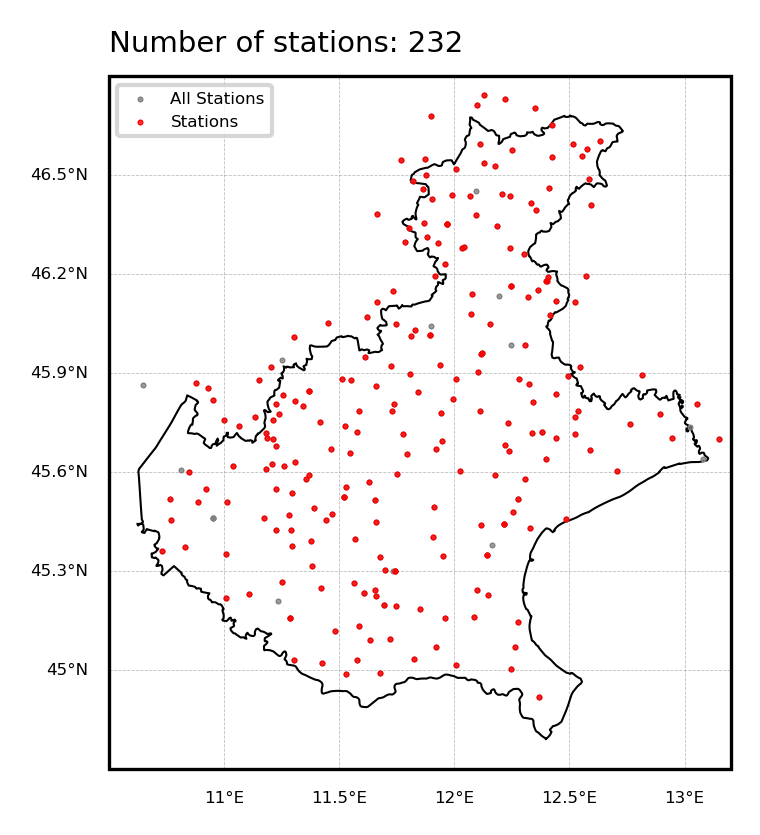

In [213]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

ax1.scatter(INFO_pd['Lon'].values, INFO_pd['Lat'].values, s=0.2, c='grey', zorder=20, label='All Stations')
ax1.scatter(wa_pd['Lon'].values, wa_pd['Lat'].values, s=0.2, c='r', zorder=20, label='Stations')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True

gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title(f'Number of stations: {len(wa_pd)}', loc='left', fontsize=7)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [214]:
points_df = pd.DataFrame({'lat': wa_pd['Lat'], 'lon': wa_pd['Lon'], 'wdays': wa_pd['N'], 'scale': wa_pd['C'],  'shape': wa_pd['W']})
points_gdf = gpd.GeoDataFrame(
    points_df,
    geometry=gpd.points_from_xy(points_df['lon'], points_df['lat']),
    crs="EPSG:4326"
)

In [215]:
# Create a GeoDataFrame for CMORPH grid cells
lon_grid, lat_grid = np.meshgrid(Clon, Clat)
grid_points = pd.DataFrame({'lon': lon_grid.ravel(), 'lat': lat_grid.ravel()})
grid_points = gpd.GeoDataFrame(
    grid_points,
    geometry=gpd.points_from_xy(grid_points['lon'], grid_points['lat']),
    crs="EPSG:4326"
)

In [216]:
# Definir la resolución espacial (en grados)
resolution = 0.1

# Ajustar las coordenadas para que la grilla esté alineada correctamente
# Desplazamos las coordenadas a la mitad de la resolución para corregir el desplazamiento
Clon_adjusted = Clon - (resolution / 2)
Clat_adjusted = Clat - (resolution / 2)

# Agregar una fila en la parte superior y una columna a la derecha
# Esto asegura que la grilla cubra toda el área y agregue el borde superior y derecho
Clon_adjusted = np.append(Clon_adjusted, Clon_adjusted[-1] + resolution)
Clat_adjusted = np.append(Clat_adjusted, Clat_adjusted[-1] + resolution)

# Crear las celdas de la grilla utilizando las coordenadas ajustadas
grid_cells = []
for i in range(len(Clon_adjusted) - 1):
    for j in range(len(Clat_adjusted) - 1):
        # Crear una celda de la grilla como un polígono rectangular (cuadrado)
        grid_cells.append(box(Clon_adjusted[i], Clat_adjusted[j], Clon_adjusted[i + 1], Clat_adjusted[j + 1]))

# Crear un GeoDataFrame con las celdas de la grilla
grid_gdf = gpd.GeoDataFrame(
    geometry=grid_cells,
    crs="EPSG:4326"
)

Text(0.0, 1.0, 'IMERG grid')

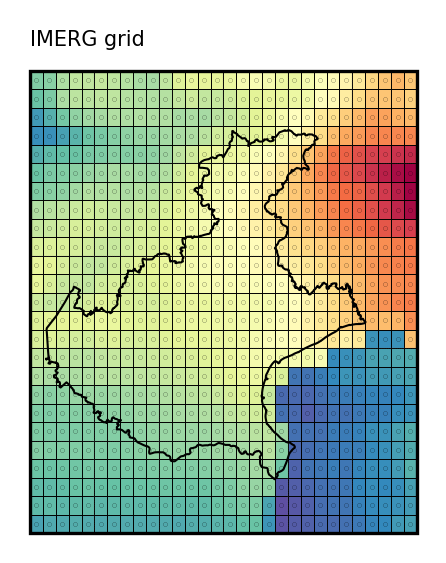

In [217]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

#=====================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

grid_gdf.boundary.plot(ax=ax1,linewidth=0.2, edgecolor='black')
ax1.plot(Clon2d, Clat2d,'.k',markersize=0.1)

a1 = ax1.pcolormesh(Clon2d, Clat2d, IMERG_data['PRE'].mean(axis=0), cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.1,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.set_title('IMERG grid', loc='left', fontsize=5)

In [218]:
# Intersección espacial: asignar puntos a las celdas de la grilla de CMORPH
joined = gpd.sjoin(points_gdf, grid_gdf, how="inner", predicate="intersects")

In [219]:
# Agrupar por celdas de la grilla y calcular el promedio de los valores de escala
aggregated = joined.groupby('index_right').agg({'wdays': 'mean', 'scale': 'mean', 'shape': 'mean'}).reset_index()

In [220]:
# Añadir los valores agregados al GeoDataFrame de la grilla
grid_gdf['wdays'] = np.nan
grid_gdf.loc[aggregated['index_right'], 'wdays'] = aggregated['wdays']

grid_gdf['scale'] = np.nan
grid_gdf.loc[aggregated['index_right'], 'scale'] = aggregated['scale']

grid_gdf['shape'] = np.nan
grid_gdf.loc[aggregated['index_right'], 'shape'] = aggregated['shape']

In [221]:
wdays_matrix = np.zeros([Cnlat, Cnlon])*np.nan
scale_matrix = np.zeros([Cnlat, Cnlon])*np.nan
shape_matrix = np.zeros([Cnlat, Cnlon])*np.nan

In [222]:
for idx, row in aggregated.iterrows():
    poly_idx = int(row['index_right'])
    grid_cell = grid_gdf.geometry.iloc[poly_idx]
    
    # Encontrar los índices de la celda en la grilla de CMORPH
    centroid_lon = np.round(grid_cell.centroid.xy[0][0], 2)
    centroid_lat = np.round(grid_cell.centroid.xy[1][0], 2)

    # lon_idx = np.where(Clon == centroid_lon)[0]
    # lat_idx = np.where(Clat == centroid_lat)[0]
    lon_idx = np.where(np.isclose(Clon, centroid_lon, atol=1e-6))[0][0]
    lat_idx = np.where(np.isclose(Clat, centroid_lat, atol=1e-6))[0][0]

    wdays_matrix[lat_idx, lon_idx] = row['wdays']
    scale_matrix[lat_idx, lon_idx] = row['scale']
    shape_matrix[lat_idx, lon_idx] = row['shape']

In [223]:
wa_pd['N'].values.min(), wa_pd['N'].values.max()

(np.int64(310), np.int64(1324))

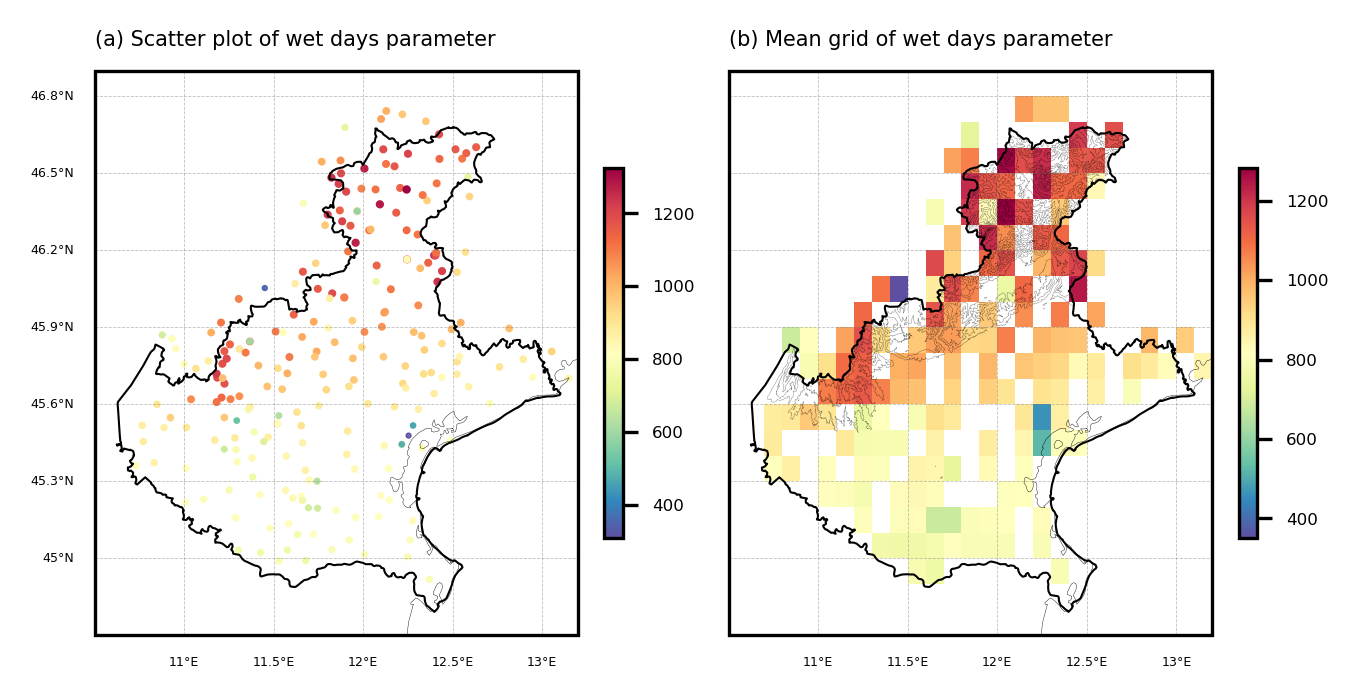

In [224]:
levels = np.arange(650, 4650, 150)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
a1 = ax1.scatter(wa_pd['Lon'].values, wa_pd['Lat'].values, s=wa_pd['N'].values/np.max(wa_pd['N'].values), c=wa_pd['N'].values, cmap=cmap)

# grid_gdf.boundary.plot(ax=ax1,linewidth=0.1, edgecolor='gray')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(a) Scatter plot of wet days parameter', loc='left', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)
a1 = ax1.pcolormesh(Clon2d, Clat2d, wdays_matrix, cmap=cmap)

# grid_gdf.boundary.plot(ax=ax1,linewidth=0.1, edgecolor='gray')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(b) Mean grid of wet days parameter', loc='left', fontsize=5)

# ============================================================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [225]:
wa_pd['C'].values.min(), wa_pd['C'].values.max()

(np.float64(8.298913740338492), np.float64(19.369711128858597))

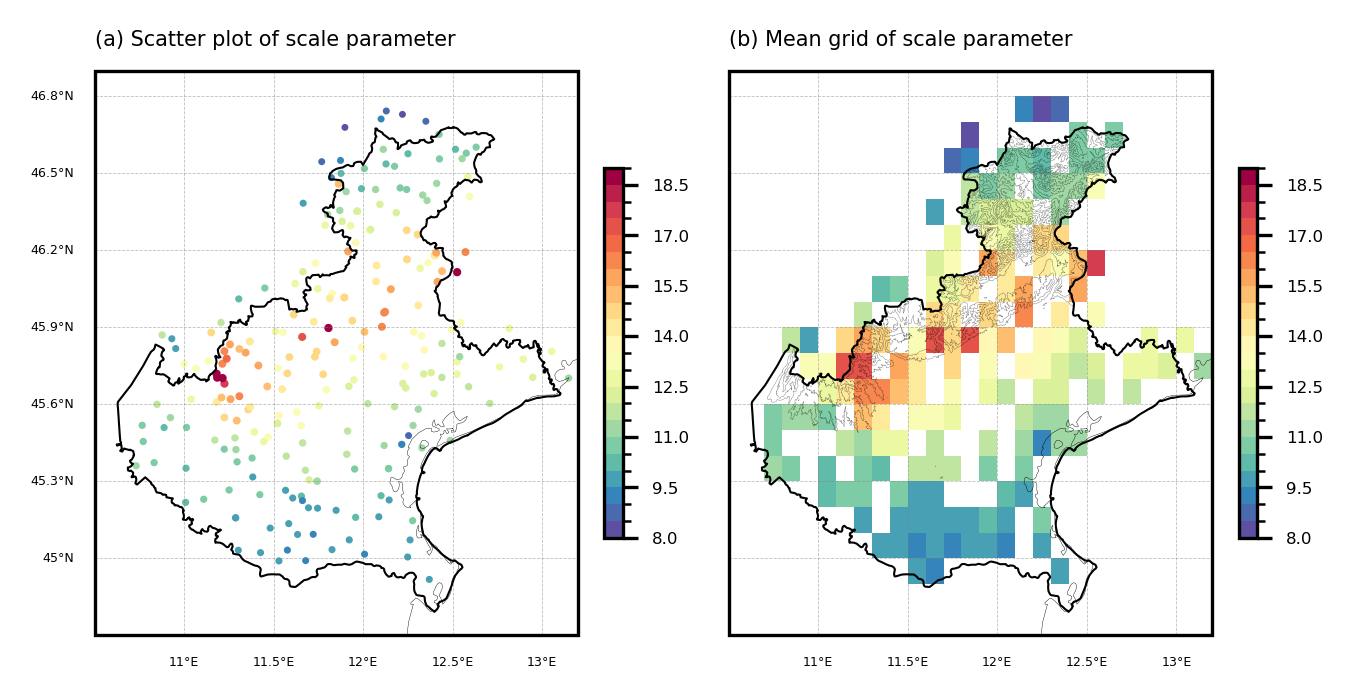

In [226]:
levels = np.arange(8, 19.5, 0.5)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
a1 = ax1.scatter(wa_pd['Lon'].values, wa_pd['Lat'].values, s=wa_pd['C'].values/np.max(wa_pd['C'].values), c=wa_pd['C'].values, cmap=cmap, norm=norm)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(a) Scatter plot of scale parameter', loc='left', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)
a1 = ax1.pcolormesh(Clon2d, Clat2d, scale_matrix, cmap=cmap, norm=norm)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(b) Mean grid of scale parameter', loc='left', fontsize=5)

# ============================================================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [227]:
wa_pd['W'].values.min(), wa_pd['W'].values.max()

(np.float64(0.5387084196281954), np.float64(1.085942018062154))

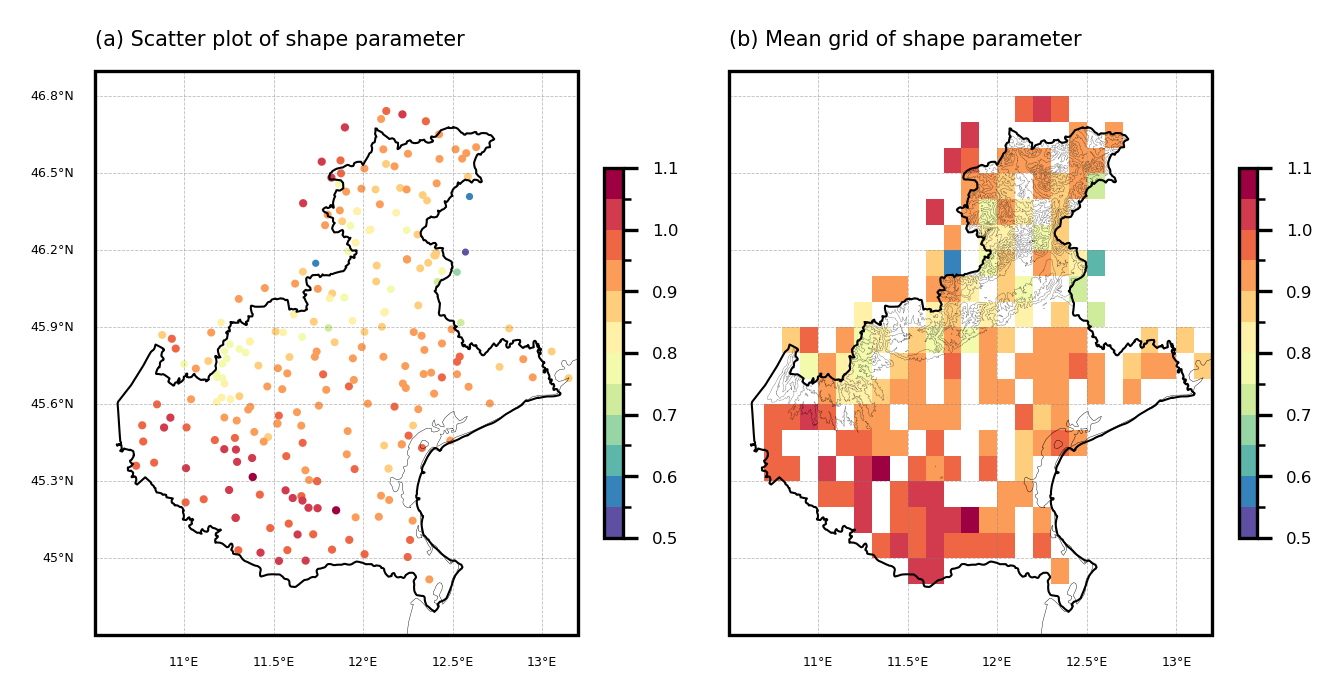

In [228]:
levels = np.arange(0.5, 1.15, 0.05)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
a1 = ax1.scatter(wa_pd['Lon'].values, wa_pd['Lat'].values, s=wa_pd['W'].values/np.max(wa_pd['W'].values), c=wa_pd['W'].values, cmap=cmap, norm=norm)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(a) Scatter plot of shape parameter', loc='left', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)
a1 = ax1.pcolormesh(Clon2d, Clat2d, shape_matrix, cmap=cmap, norm=norm)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(b) Mean grid of shape parameter', loc='left', fontsize=5)

# ============================================================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

## WEIBULL PARAMETERS FOR IMERG

In [229]:
IMERG_N = np.zeros([Cnlat, Cnlon])
IMERG_S = np.zeros([Cnlat, Cnlon])
IMERG_W = np.zeros([Cnlat, Cnlon])

CMORPH = IMERG_data['PRE'].values

for i in range(Cnlat):
    for j in range(Cnlon):
        pre_tmp = CMORPH[:,i,j]
        WEIBULL = wei_fit_update(pre_tmp[pre_tmp>1])
        IMERG_N[i,j] = WEIBULL[0]
        IMERG_S[i,j] = WEIBULL[1]
        IMERG_W[i,j] = WEIBULL[2]

In [230]:
IMERG_N = np.where(~np.isnan(shape_matrix), IMERG_N, np.nan)
IMERG_S = np.where(~np.isnan(shape_matrix), IMERG_S, np.nan)
IMERG_W = np.where(~np.isnan(shape_matrix), IMERG_W, np.nan)

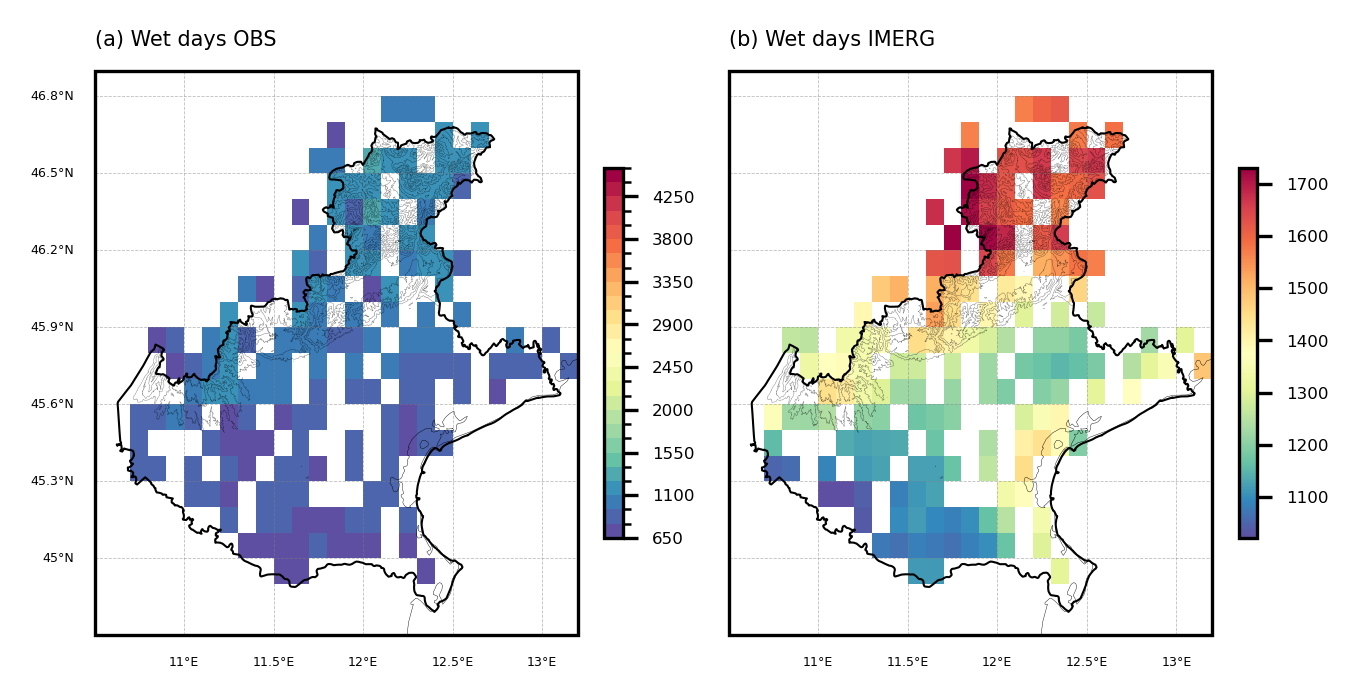

In [231]:
levels = np.arange(650, 4650, 150)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)
a1 = ax1.pcolormesh(Clon2d, Clat2d, wdays_matrix, cmap=cmap, norm=norm)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(a) Wet days OBS', loc='left', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)
a1 = ax1.pcolormesh(Clon2d, Clat2d, IMERG_N, cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(b) Wet days IMERG', loc='left', fontsize=5)

# ============================================================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

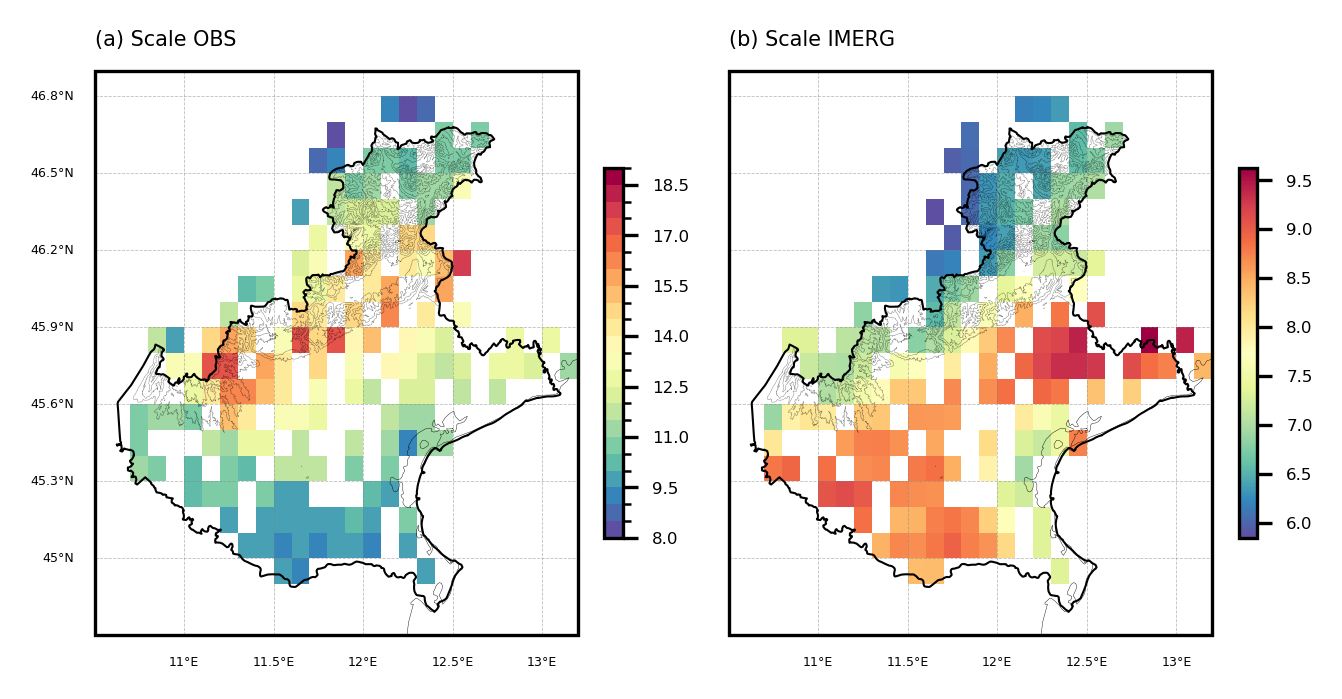

In [232]:
levels = np.arange(8, 19.5, 0.5)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)
a1 = ax1.pcolormesh(Clon2d, Clat2d, scale_matrix, cmap=cmap, norm=norm)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(a) Scale OBS', loc='left', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)
a1 = ax1.pcolormesh(Clon2d, Clat2d, IMERG_S, cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(b) Scale IMERG', loc='left', fontsize=5)

# ============================================================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

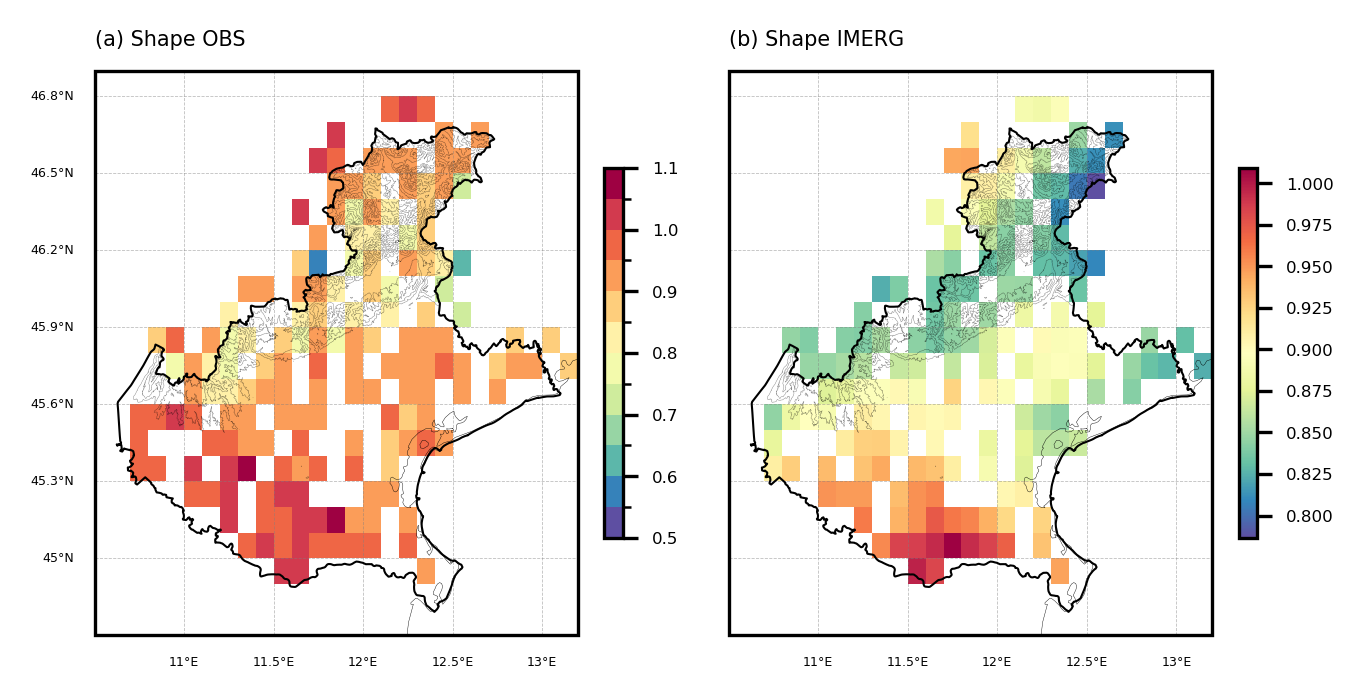

In [233]:
levels = np.arange(0.5, 1.15, 0.05)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)
a1 = ax1.pcolormesh(Clon2d, Clat2d, shape_matrix, cmap=cmap, norm=norm)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(a) Shape OBS', loc='left', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
ax1.add_geometries(Veneto_DEM.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.1, alpha=0.5)
a1 = ax1.pcolormesh(Clon2d, Clat2d, IMERG_W, cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(b) Shape IMERG', loc='left', fontsize=5)

# ============================================================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)